# Навигация и краткое описание

**Разделы:**
- XGBoost
- LightGBM
- CatBoost

# Подготовка к работе с моделями

In [2]:
import pandas as pd 
from matplotlib import pyplot as plt

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import sys
sys.path.append('..')
from utils import load_processed_data, ModelsRegressionHistory

# Заранее установим несколько констант
RANDOM_STATE = 42

# Загрузка данных
X_train, X_test, y_train, y_test = load_processed_data()
history_models = ModelsRegressionHistory()

# Теория

Бустинг - последовательно обучает модели, где каждая следующая модель исправляет ошибки предыдущих, фокусируясь на плохо предсказанных примерах. Итоговое предсказание формируется путем взвешенного объединения всех моделей.

**более подробную теорию вы можете просмотреть в 2 блокноте*

# Создание моделей

## XGBoost

Считается самой популярной модификацией градиентного бустинга на сегодняшний день. Большая часть соревнований с использованием классического машинного обучения выигрывается с использованием этой модели.

XGBoost - это "золотой стандарт" машинного обучения с табличными данными \[[источник](https://www.geeksforgeeks.org/machine-learning/xgboost-for-regression/)\]. 
Давайте разберём по какой причине XGBoost так хороша:
1) Регуляризация
    В функцию потерь добавлена регуляризация, которая предотвращает переобучение.
    $ Obj(0) = MSE(0) +  Lasso(0)$
    * MSE(0) - функция потерь
    * Lasso(0) - регуляризатор
2) Разбиение
    Построение дерева требует поиска лучшего разбиения по каждому признаку. XGBoost вместо того, чтоб брать весь датасет из 10.000 обьектов (цифра приведена к примеру) возьмёт 100 случайных объектов и выполнит разбиение по ним - это сэкономит огромное количество времени, при минимальной потере качества
3) Разряженные данные
    В датасетах полно пропущенных значений, а также нулей. XGBoost умеет обрабатывать такие данные. Модель автоматически сделает "виток" в дереве для таких данных.
4) Системная оптимизация
    * Модель может разбивать данные параллельно на всех доступных ядрах системы.
    * Часто используемые ланные кэшируются

*Мы не будем на данный момент выжимать все соки из каждой последующей модели. И если сейчас получится приемлимый результат, знайте что это не лучший показатель этой модели.*

In [3]:
# хорошим тоном при разработке моделей является вынесение параметров в отдельный словарь, 
# что мы сейчас и сделаем

params = {
    'objective': 'reg:squarederror', 
    'max_depth': 3,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': RANDOM_STATE
}

In [4]:
xgbr = XGBRegressor(
    **params
)
xgbr.fit(X_train, y_train)
y_pred = xgbr.predict(X_test)

In [5]:
history_models.add_model(xgbr, "tree_model", xgbr.get_params(), "XGBR", y_true=y_test, y_pred=y_pred)
history_models.to_dataframe()

,Модели,Класс модели,Параметры модели,Заметки,MAE,MSE,RMSE,R^2,MAPE,MSLE,RMSLE
0,XGBRegressor,tree_model,"{'objective': 'reg:squarederror', 'base_score'...",XGBR,0.1793,0.0593,0.2436,0.952,0.02,0.0006,0.0248


А так же мы можем просматреть влияние фичь на предсказания. Какие свойства обьекта большего всего влияют на предсказание.

In [26]:
importance = xgbr.get_booster().get_score(importance_type='weight')
importance_df = pd.DataFrame(
    data={
            'features': list(importance.keys()),
            'score': list(importance.values())
        },
).sort_values(by=['score'], axis=0, ascending=False, ignore_index=True)
importance_df.head()

,features,score
0,duration,110.0
1,days_left,103.0
2,flight_value,89.0
3,class_Economy,49.0
4,stops_encoded,46.0


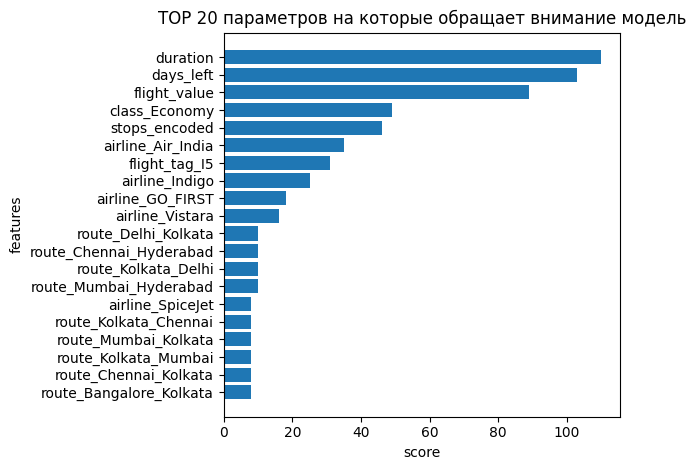

In [38]:
plt.barh(
    importance_df['features'].head(20)[::-1],
    importance_df['score'].head(20)[::-1],
)
plt.title('TOP 20 параметров на которые обращает внимание модель')
plt.ylabel('features')
plt.xlabel('score')
plt.tight_layout()
plt.show()

## LightGBM

## CatBoost